In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids, plot_res_gp, my_plot_convergence
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys

from data_providers.price_history_32_autoenc_data_gen import PriceHistoryAutoEncoderDatasetGenerator
from models.model_32_price_history_autoencoder import PriceHistoryAutoencoder
from data_providers.data_provider_32_price_history_autoencoder import PriceHistoryAutoEncDataProvider
#from gp_opt.price_history_27_gp_opt import PriceHistoryGpOpt

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [4]:
batch_size = 1

In [5]:
#full_train_size = 55820
#train_size = 55800
#small_train_size = 6000 #just because of performance reasons, no statistics behind this decision
#test_size = 6200

In [6]:
data_path = '../../../../Dropbox/data'

In [7]:
phae_path = data_path + '/price_hist_autoencoder'

In [8]:
csv_in = '../price_history_03_seq_start_suddens_trimmed.csv'
assert path.isfile(csv_in)

In [9]:
npz_one_instance = phae_path + '/price_history_seqs_dates_normed_one_instance_train.npz'

npz_one_instance_prefix = npz_one_instance[:-len('_train.npz')]

### Once generate data

In [9]:
df = pd.read_csv(csv_in, index_col=0, quoting=csv.QUOTE_ALL, encoding='utf-8')
df.shape

(689, 684)

In [26]:
npz_path = phae_path + '/price_history_full_seqs.npz'

In [19]:
%%time
train_pack, test_pack = PriceHistoryAutoEncoderDatasetGenerator(random_state=random_state).createAndSaveDataset(
    csv_in = csv_in,
    do_global_norm_scale = True,
    save_files_dic = {
        'train': npz_path,
        'test': None,
    }
)

CPU times: user 1.02 s, sys: 84 ms, total: 1.1 s
Wall time: 1.3 s


In [25]:
#sku_ids
#inputs
#sequence lengths
#masks
#dates
for bb in train_pack.get_data():
    print bb.shape

(689,)
(689, 682)
(689,)
(689, 682)
(689, 682)


In [32]:
%%time
merged_dic = PriceHistoryAutoEncoderDatasetGenerator.merge_date_info(npz_path=npz_path)

CPU times: user 11.8 s, sys: 16 ms, total: 11.8 s
Wall time: 11.8 s


In [40]:
max_seq_len = merged_dic['inputs'].shape[1]
max_seq_len

682

In [43]:
assert len(np.argwhere(merged_dic['extra_inputs'][0][:, 0] == -1).flatten()) + merged_dic['sequence_lengths'][0] \
    == max_seq_len, "just checking if our conversion occured as it should have"

In [45]:
npz_dates = phae_path + '/price_history_full_seqs_dates.npz'
#np.savez(npz_dates, **merged_dic)

In [46]:
dic = np.load(npz_dates)
for key, val in dic.iteritems():
    print key, ",", val.shape

inputs , (689, 682, 7)
sku_ids , (689,)
sequence_masks , (689, 682)
extra_inputs , (689, 682, 6)
sequence_lengths , (689,)


In [47]:
years = dic['extra_inputs'][:, :, 3]
years.shape

(689, 682)

In [51]:
years_flat = years.flatten()
years_flat.shape

(469898,)

In [52]:
years_filtered = years_flat[years_flat >= 0]
years_filtered.shape

(119295,)

In [54]:
np.mean(years_filtered)

2016.7819606856951

In [55]:
np.std(years_filtered)

0.41596840166451909

In [80]:
%%time
norm_dates_dic = PriceHistoryAutoEncoderDatasetGenerator.normalize_date_info(npz_dates)
for key, val in norm_dates_dic.iteritems():
    print key, ",", val.shape

inputs , (689, 682, 7)
sku_ids , (689,)
sequence_masks , (689, 682)
extra_inputs , (689, 682, 6)
sequence_lengths , (689,)
CPU times: user 128 ms, sys: 12 ms, total: 140 ms
Wall time: 139 ms


In [94]:
norm_dates_dic['extra_inputs'][:, :, 0]

array([[ 1.67902267,  1.67902267,  1.67902267, ..., -1.        ,
        -1.        , -1.        ],
       [ 1.67902267,  1.67902267,  1.67902267, ..., -1.        ,
        -1.        , -1.        ],
       [ 1.67902267,  1.67902267,  1.67902267, ..., -1.        ,
        -1.        , -1.        ],
       ..., 
       [ 1.67902267,  1.67902267,  1.67902267, ..., -1.        ,
        -1.        , -1.        ],
       [ 1.67902267,  1.67902267,  1.67902267, ..., -1.        ,
        -1.        , -1.        ],
       [ 1.67902267,  1.67902267,  1.67902267, ..., -1.        ,
        -1.        , -1.        ]], dtype=float32)

In [96]:
npz_dates = phae_path + '/price_history_seqs_dates_normed_train.npz'
np.savez(npz_dates, **norm_dates_dic)

In [98]:
final_dic = np.load(npz_dates)

In [99]:
for key, val in final_dic.iteritems():
    print key, ",", val.shape

inputs , (689, 682, 7)
sku_ids , (689,)
sequence_masks , (689, 682)
extra_inputs , (689, 682, 6)
sequence_lengths , (689,)


In [101]:
small_dic = {}
for key, val in final_dic.iteritems():
    small_dic[key] = val[:1]
    print key, ",", small_dic[key].shape

inputs , (1, 682, 7)
sku_ids , (1,)
sequence_masks , (1, 682)
extra_inputs , (1, 682, 6)
sequence_lengths , (1,)


In [102]:
np.savez(npz_one_instance, **small_dic)

In [10]:
# PriceHistoryDatasetGenerator.create_subsampled(inpath=npz_train_full, target_size=55800,
#                                                outpath=npz_train_trimmed, random_state=random_state)

### Step 1 - collect data

In [15]:
dp = PriceHistoryAutoEncDataProvider(npz_path=npz_one_instance_prefix, batch_size=1, with_EOS=False)
for data in dp.datalist:
    print data.shape

(1, 682, 7)
(1, 682, 6)


In [32]:
dp = PriceHistoryAutoEncDataProvider(npz_path=npz_one_instance_prefix, batch_size=1, with_EOS=False, ts_max_len=210)
for data in dp.datalist:
    print data.shape

(1, 210, 7)
(1, 210, 6)


(1, 682, 7)  
(1, 682, 6)

In [14]:
# for item in dp.next():
#     print item.shape

### Step 2 - Build model

In [10]:
model = PriceHistoryAutoencoder(rng=random_state, dtype=dtype, config=config)

In [11]:
# graph = model.getGraph(batch_size=batch_size,
#                        enc_num_units = 10,
#                        dec_num_units = 10,
#                        ts_len=210)

Tensor("data/strided_slice:0", shape=(50, 210), dtype=float32)

210
Tensor("inputs/unstack:0", shape=(50, 7), dtype=float32)

Tensor("encoder_rnn_layer/rnn/gru_cell_209/add:0", shape=(50, 10), dtype=float32)

Tensor("encoder_state_out_process/Elu:0", shape=(50, 2), dtype=float32)

Tensor("decoder_state_in_process/Elu:0", shape=(50, 10), dtype=float32)

210
Tensor("dec_extra_ins/unstack:0", shape=(50, 6), dtype=float32)

decoder_outputs len: 210
Tensor("decoder_rnn_layer/rnn/gru_cell/add:0", shape=(50, 10), dtype=float32)

Tensor("decoder_outs/stack:0", shape=(50, 210, 10), dtype=float32)
Tensor("decoder_outs/Reshape:0", shape=(10500, 10), dtype=float32)

Tensor("readout_affine/Identity:0", shape=(10500, 1), dtype=float32)
Tensor("readout_affine/Reshape:0", shape=(50, 210), dtype=float32)

Tensor("error/Select:0", shape=(50, 210), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)
Tensor("error/Mean:0", shape=(), dtype=float32)

In [12]:
#show_graph(graph)

## Quick test run

In [15]:
def experiment():
    return model.run(npz_path=npz_one_instance_prefix,
                     epochs=100,
                     batch_size = batch_size,
                     enc_num_units = 400,
                     dec_num_units = 400,
                     ts_len=210,
                     learning_rate = 1e-4,
                     preds_gather_enabled = False,
                    )
dyn_stats = experiment()

epochs: 100
dec_num_units: 400
learning_rate: 0.0001
enc_num_units: 400
End Epoch 01 (4.461 secs): err(train) = 0.051802
End Epoch 02 (0.446 secs): err(train) = 0.026912
End Epoch 03 (0.453 secs): err(train) = 0.014934
End Epoch 04 (0.449 secs): err(train) = 0.012791
End Epoch 05 (0.454 secs): err(train) = 0.014734
End Epoch 06 (0.446 secs): err(train) = 0.015680
End Epoch 07 (0.454 secs): err(train) = 0.014043
End Epoch 08 (0.449 secs): err(train) = 0.010638
End Epoch 09 (0.454 secs): err(train) = 0.006924
End Epoch 10 (0.446 secs): err(train) = 0.004112
End Epoch 11 (0.453 secs): err(train) = 0.002822
End Epoch 12 (0.448 secs): err(train) = 0.002983
End Epoch 13 (0.454 secs): err(train) = 0.003953
End Epoch 14 (0.446 secs): err(train) = 0.004882
End Epoch 15 (0.453 secs): err(train) = 0.005164
End Epoch 16 (0.449 secs): err(train) = 0.004666
End Epoch 17 (0.450 secs): err(train) = 0.003652
End Epoch 18 (0.447 secs): err(train) = 0.002543
End Epoch 19 (0.450 secs): err(train) = 0.0017

([<matplotlib.figure.Figure at 0x7fe0ac2cd910>],
 [<matplotlib.axes._subplots.AxesSubplot at 0x7fdfefdcc410>])

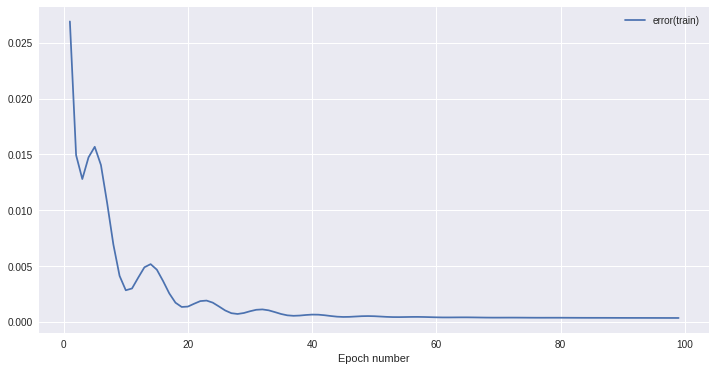

In [17]:
dyn_stats.plotStats()

#### Conclusion
For one instance that is the most easy case it seems to be trainable, let's get the predicted values to observe how it actually looks like

### Step 3 training the network

In [10]:
model = PriceHistoryAutoencoder(rng=random_state, dtype=dtype, config=config)

In [11]:
batch_size

1

In [12]:
npz_test = npz_one_instance_prefix + '_test.npz'
assert path.isfile(npz_test)
path.abspath(npz_test)

'/home/studenthp/Dropbox/data/price_hist_autoencoder/price_history_seqs_dates_normed_one_instance_test.npz'

In [13]:
def experiment():
    return model.run(npz_path=npz_one_instance_prefix,
                     epochs=100,
                     batch_size = batch_size,
                     enc_num_units = 400,
                     dec_num_units = 400,
                     ts_len=210,
                     learning_rate = 1e-4,
                     preds_gather_enabled = True,
                    )

In [14]:
#%%time
dyn_stats, preds_dict, targets = get_or_run_nn(experiment, filename='032_autoencoder_000',
                                              nn_runs_folder = data_path + "/nn_runs")

epochs: 100
dec_num_units: 400
learning_rate: 0.0001
enc_num_units: 400
End Epoch 01 (4.590 secs): err(train) = 0.029315
End Epoch 02 (0.457 secs): err(train) = 0.019486
End Epoch 03 (0.450 secs): err(train) = 0.018148
End Epoch 04 (0.455 secs): err(train) = 0.017070
End Epoch 05 (0.449 secs): err(train) = 0.014101
End Epoch 06 (0.457 secs): err(train) = 0.010726
End Epoch 07 (0.448 secs): err(train) = 0.008404
End Epoch 08 (0.459 secs): err(train) = 0.007487
End Epoch 09 (0.452 secs): err(train) = 0.007176
End Epoch 10 (0.458 secs): err(train) = 0.006478
End Epoch 11 (0.451 secs): err(train) = 0.005189
End Epoch 12 (0.455 secs): err(train) = 0.003809
End Epoch 13 (0.452 secs): err(train) = 0.002897
End Epoch 14 (0.458 secs): err(train) = 0.002591
End Epoch 15 (0.452 secs): err(train) = 0.002549
End Epoch 16 (0.454 secs): err(train) = 0.002336
End Epoch 17 (0.451 secs): err(train) = 0.001847
End Epoch 18 (0.460 secs): err(train) = 0.001333
End Epoch 19 (0.454 secs): err(train) = 0.0011

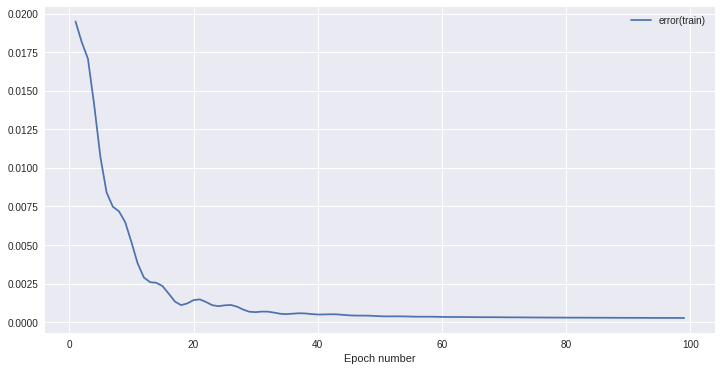

In [15]:
dyn_stats.plotStats()
plt.show()

In [16]:
r2_scores = [r2_score(y_true=targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(targets))]

In [17]:
ind = np.argmin(r2_scores)
ind

0

In [18]:
reals = targets[ind]
preds = preds_dict[ind]

In [19]:
r2_score(y_true=reals, y_pred=preds)

0.89776930088972395

In [20]:
#sns.tsplot(data=dp.inputs[ind].flatten())

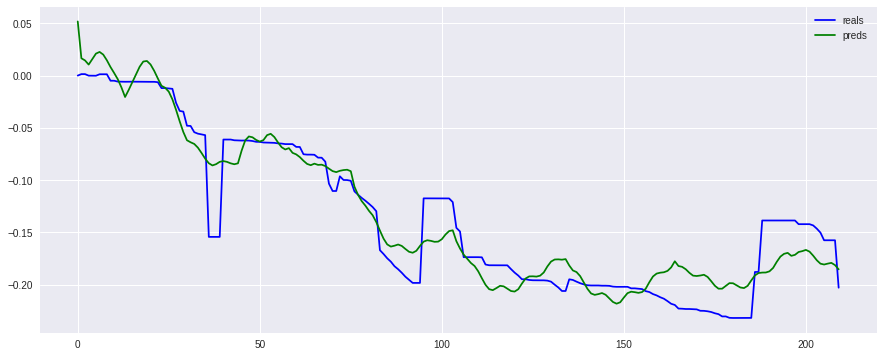

In [21]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [22]:
%%time
dtw_scores = [fastdtw(targets[ind], preds_dict[ind])[0]
             for ind in range(len(targets))]

CPU times: user 32 ms, sys: 12 ms, total: 44 ms
Wall time: 36.2 ms


In [23]:
np.mean(dtw_scores)

3.3418800933828439

In [24]:
coint(preds, reals)

(-2.7974720536922266,
 0.16649034247125227,
 array([-3.94960898, -3.36552113, -3.06480509]))

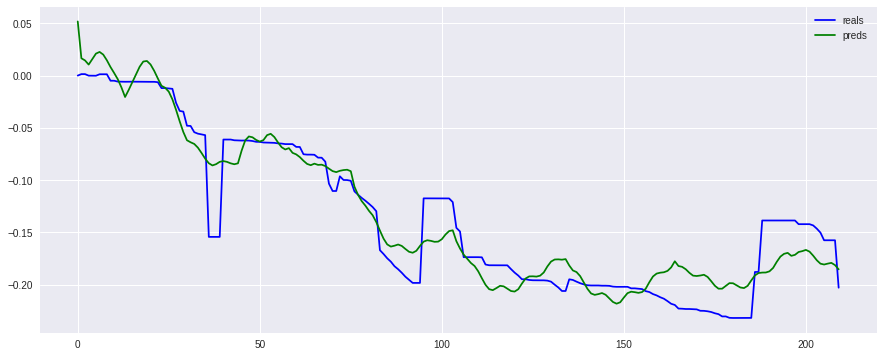

In [25]:
cur_ind = np.random.randint(len(targets))
reals = targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b', label='reals')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

### Conclusion
So we see visually that the autoencoder for the time series at least for the very easy case of training (super-overfitting!!) on only one instance it works pretty well, at the end we have an autoencoder that is able to resemble the original input